# Generative models

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Setup

In [1]:
!nvidia-smi

Sun May 11 19:20:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  |   00000000:1C:00.0  On |                  N/A |
|  0%   48C    P8             17W /  130W |    1340MiB /   6144MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

Select the device to use

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Prepare the dataset

Load the dataset. The data should be placed in the `./data` directory with the following structure:

```
data
├── 00000
│   ├── 00000_0000.jpg
│       ├── 00000_0000.jpg
|   ├── 00000_00001
│       ├── 00000_0001.jpg
```

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

images = ImageFolder("data/", transform=transform)
images_count = len(images)
num_classes = len(images.classes)

print(f"Number of images: {images_count}")
print(f"Number of classes: {num_classes}")

Number of images: 39209
Number of classes: 43


Train-test split

In [5]:
from torch.utils.data import random_split

test_size = 0.2

max_train_count = None
train_count = min(int(images_count * (1 - test_size)), max_train_count if max_train_count else float('inf'))
test_count = images_count - train_count

train_ds, test_ds = random_split(images, [train_count, test_count])

batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Number of training images: {len(train_dl.dataset)}")
print(f"Number of test images: {len(test_dl.dataset)}")

Number of training images: 31367
Number of test images: 7842


Show samples

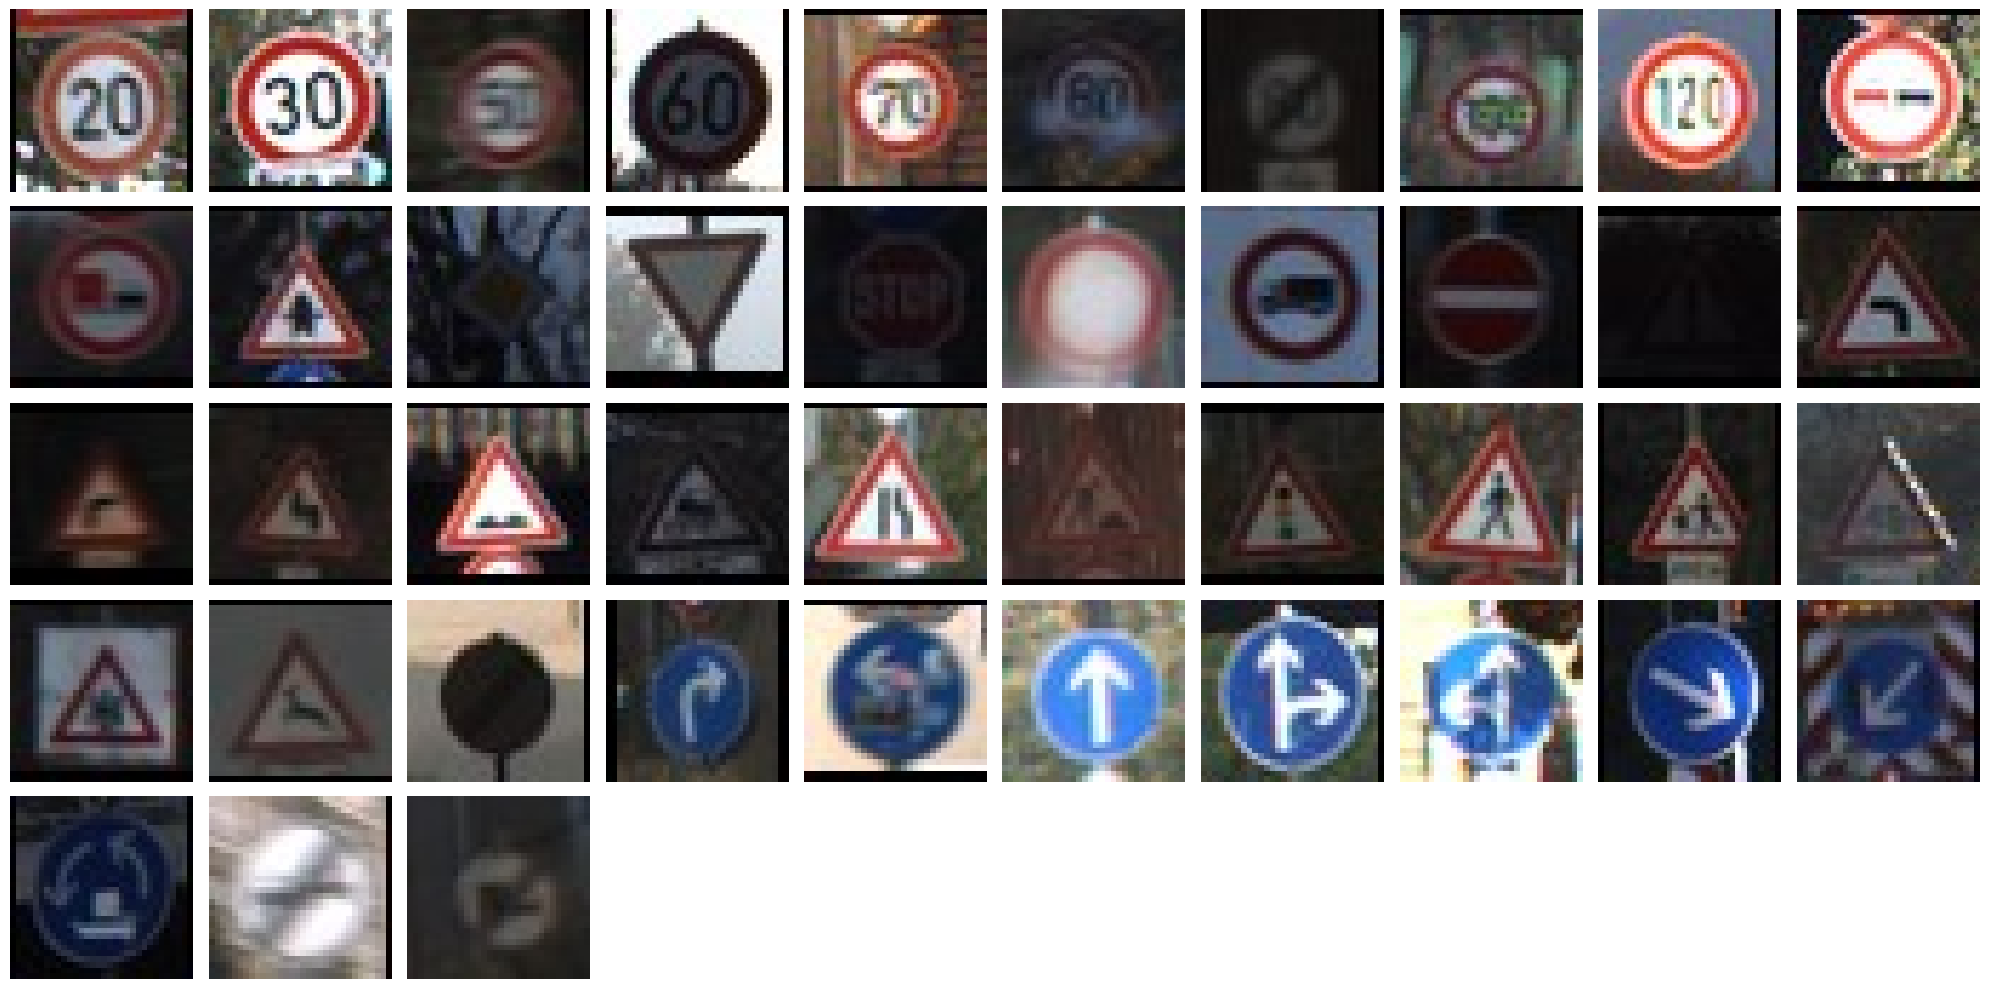

In [12]:
from collections import defaultdict
import random
import torch
from utils import denormalize_batch
from display import plot_images

class_idxs = defaultdict(list)
for idx, (_, label) in enumerate(images):
    class_idxs[label].append(idx)

sample_idxs = [random.choice(class_idxs[c]) for c in range(num_classes)]
samples = [images[i][0] for i in sample_idxs]

batch = torch.stack(samples)
batch = denormalize_batch(batch, mean=[0.5]*3, std=[0.5]*3).clamp(0, 1)
plot_images(list(batch), ncols=10)

# VAE

## Create model

In [11]:
from gnn import VariationalAutoencoder as VAE
from gnn import VAETrainer
import torch.optim as optim
import torch.nn as nn


IMG_CHANNELS = 3
latent_dim = 100

# model
vae_model = VAE(IMG_CHANNELS, latent_dim=latent_dim).to(device)

# optimizers
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001)
vae_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=vae_optimizer, gamma=0.99)

# trainer
vae_trainer = VAETrainer(
    vae_model=vae_model,
    optimizer=vae_optimizer,
    scheduler=vae_scheduler,
    latent_dim=latent_dim,
    device=device
)

## Training

Epoch 1/100: Total Loss: 736.4596, Recon Loss: 702.9068, KLD Loss: 33.5528


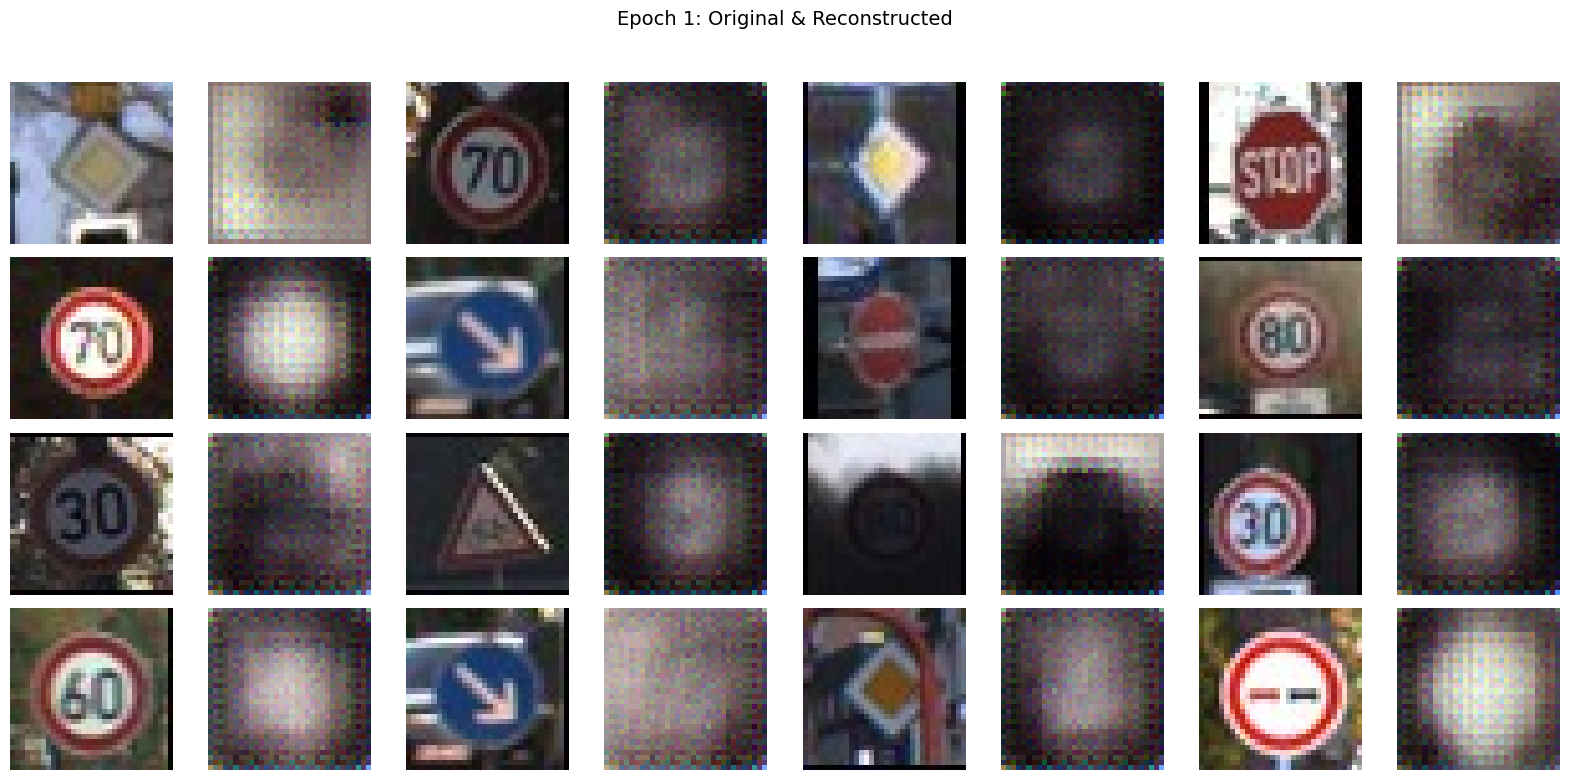

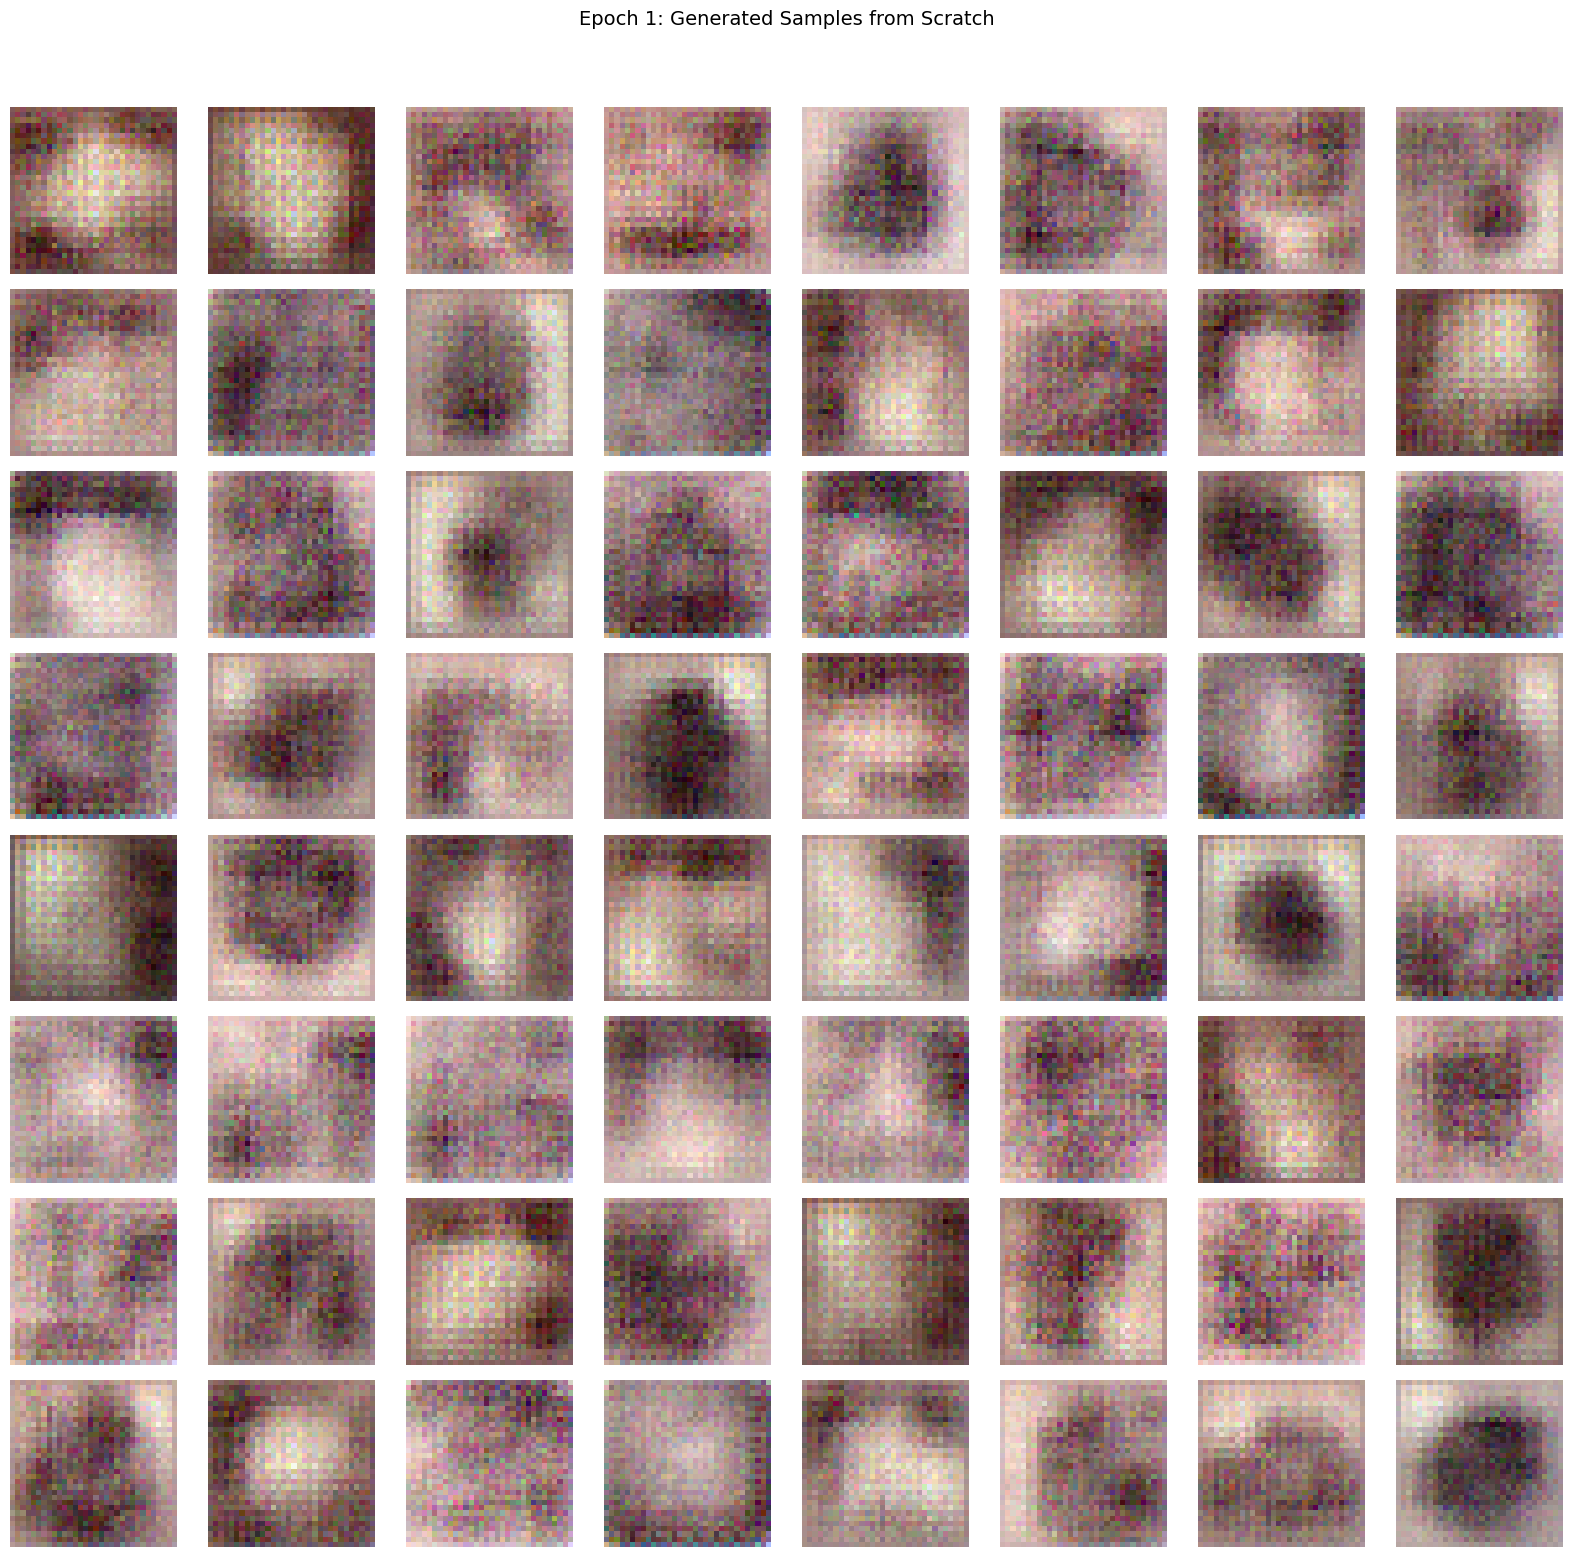

Epoch 2/100: Total Loss: 371.8264, Recon Loss: 336.5362, KLD Loss: 35.2902
Epoch 3/100: Total Loss: 321.7819, Recon Loss: 283.8976, KLD Loss: 37.8843
Epoch 4/100: Total Loss: 286.3922, Recon Loss: 247.1595, KLD Loss: 39.2327
Epoch 5/100: Total Loss: 261.3746, Recon Loss: 221.7901, KLD Loss: 39.5844
Epoch 6/100: Total Loss: 237.2963, Recon Loss: 197.1244, KLD Loss: 40.1719
Epoch 7/100: Total Loss: 222.8085, Recon Loss: 182.6980, KLD Loss: 40.1105
Epoch 8/100: Total Loss: 211.3043, Recon Loss: 171.4226, KLD Loss: 39.8818
Epoch 9/100: Total Loss: 203.4394, Recon Loss: 163.5393, KLD Loss: 39.9001
Epoch 10/100: Total Loss: 196.6836, Recon Loss: 156.8082, KLD Loss: 39.8753
Epoch 11/100: Total Loss: 190.5033, Recon Loss: 150.5753, KLD Loss: 39.9280


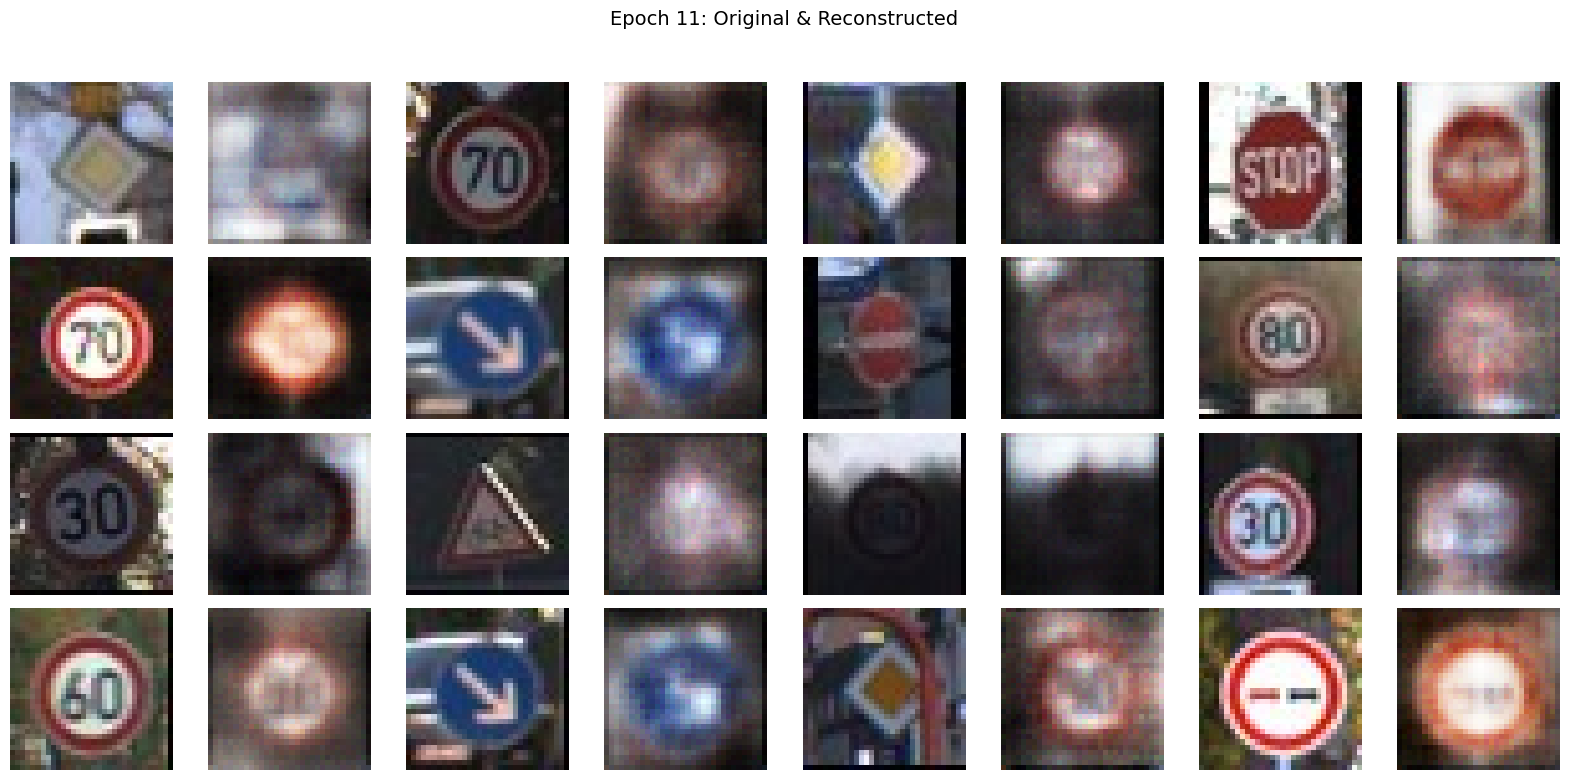

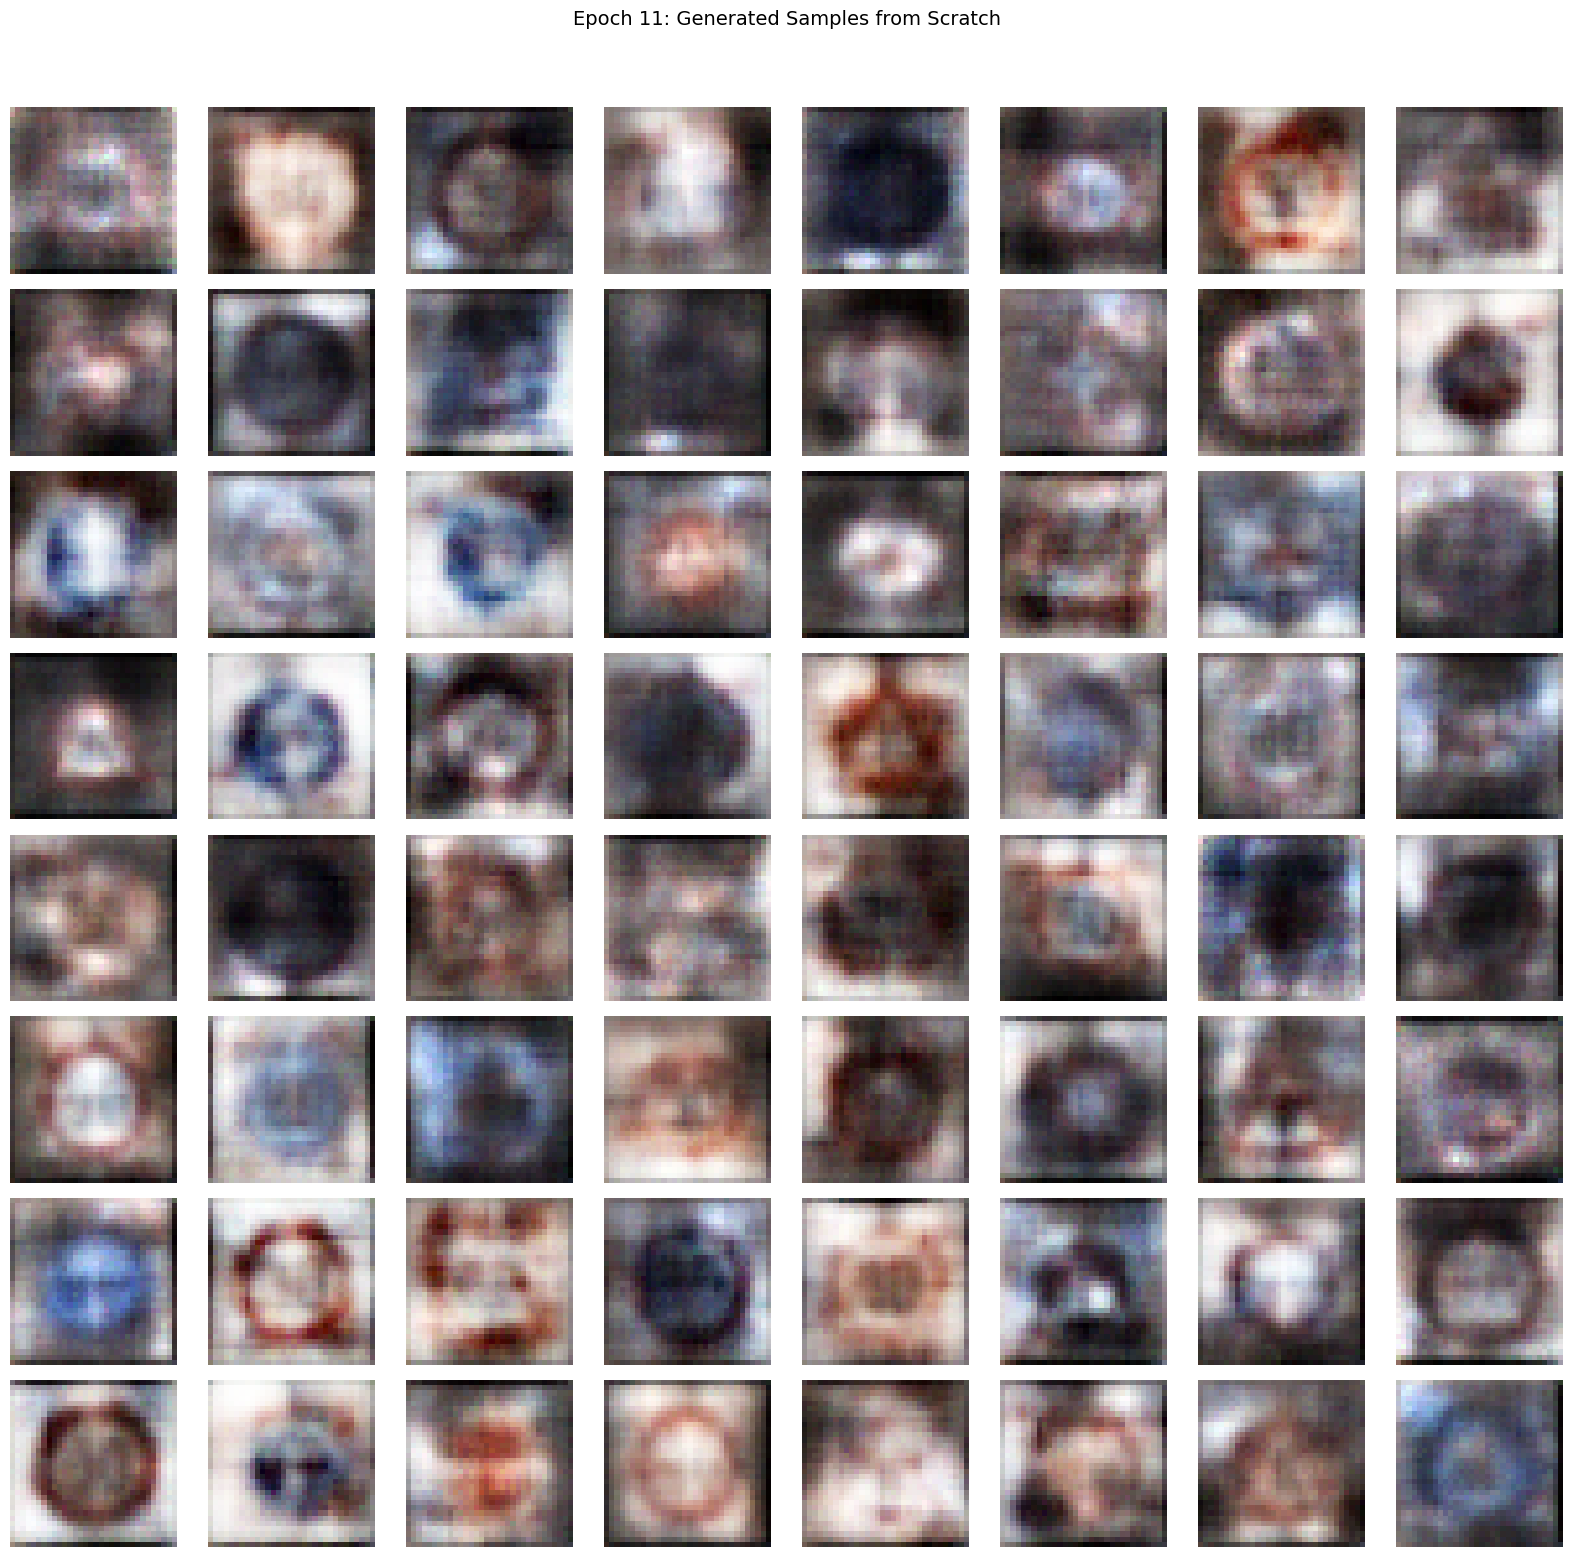

Epoch 12/100: Total Loss: 185.0275, Recon Loss: 145.0168, KLD Loss: 40.0108
Epoch 13/100: Total Loss: 180.5830, Recon Loss: 140.3313, KLD Loss: 40.2517
Epoch 14/100: Total Loss: 176.2387, Recon Loss: 135.9249, KLD Loss: 40.3138
Epoch 15/100: Total Loss: 173.5795, Recon Loss: 132.9473, KLD Loss: 40.6322
Epoch 16/100: Total Loss: 170.3228, Recon Loss: 129.4577, KLD Loss: 40.8651
Epoch 17/100: Total Loss: 167.9661, Recon Loss: 126.9535, KLD Loss: 41.0126
Epoch 18/100: Total Loss: 165.2141, Recon Loss: 124.0117, KLD Loss: 41.2023
Epoch 19/100: Total Loss: 162.9090, Recon Loss: 121.6336, KLD Loss: 41.2753
Epoch 20/100: Total Loss: 160.9194, Recon Loss: 119.4174, KLD Loss: 41.5020
Epoch 21/100: Total Loss: 159.1201, Recon Loss: 117.4002, KLD Loss: 41.7198


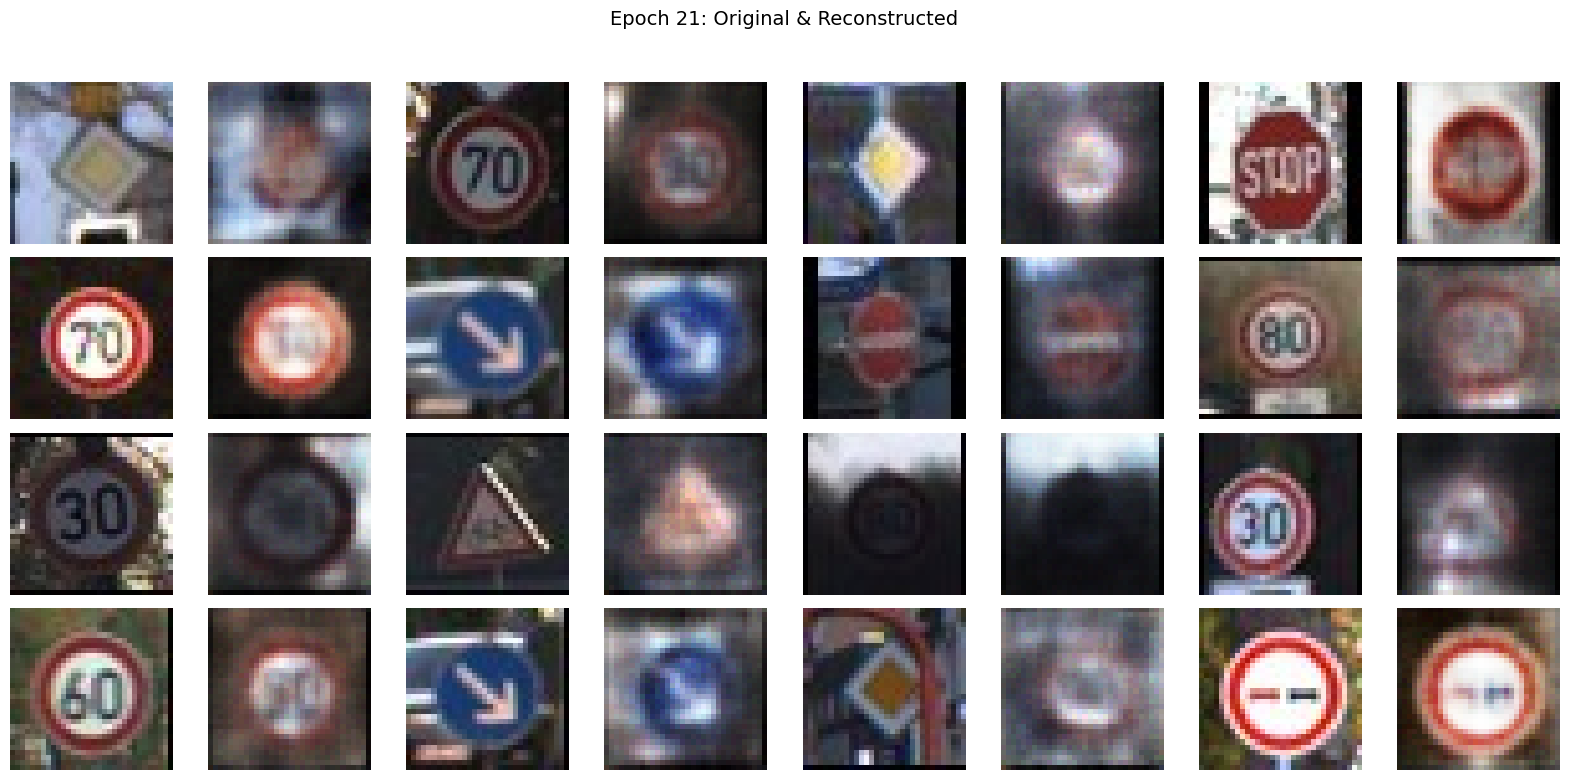

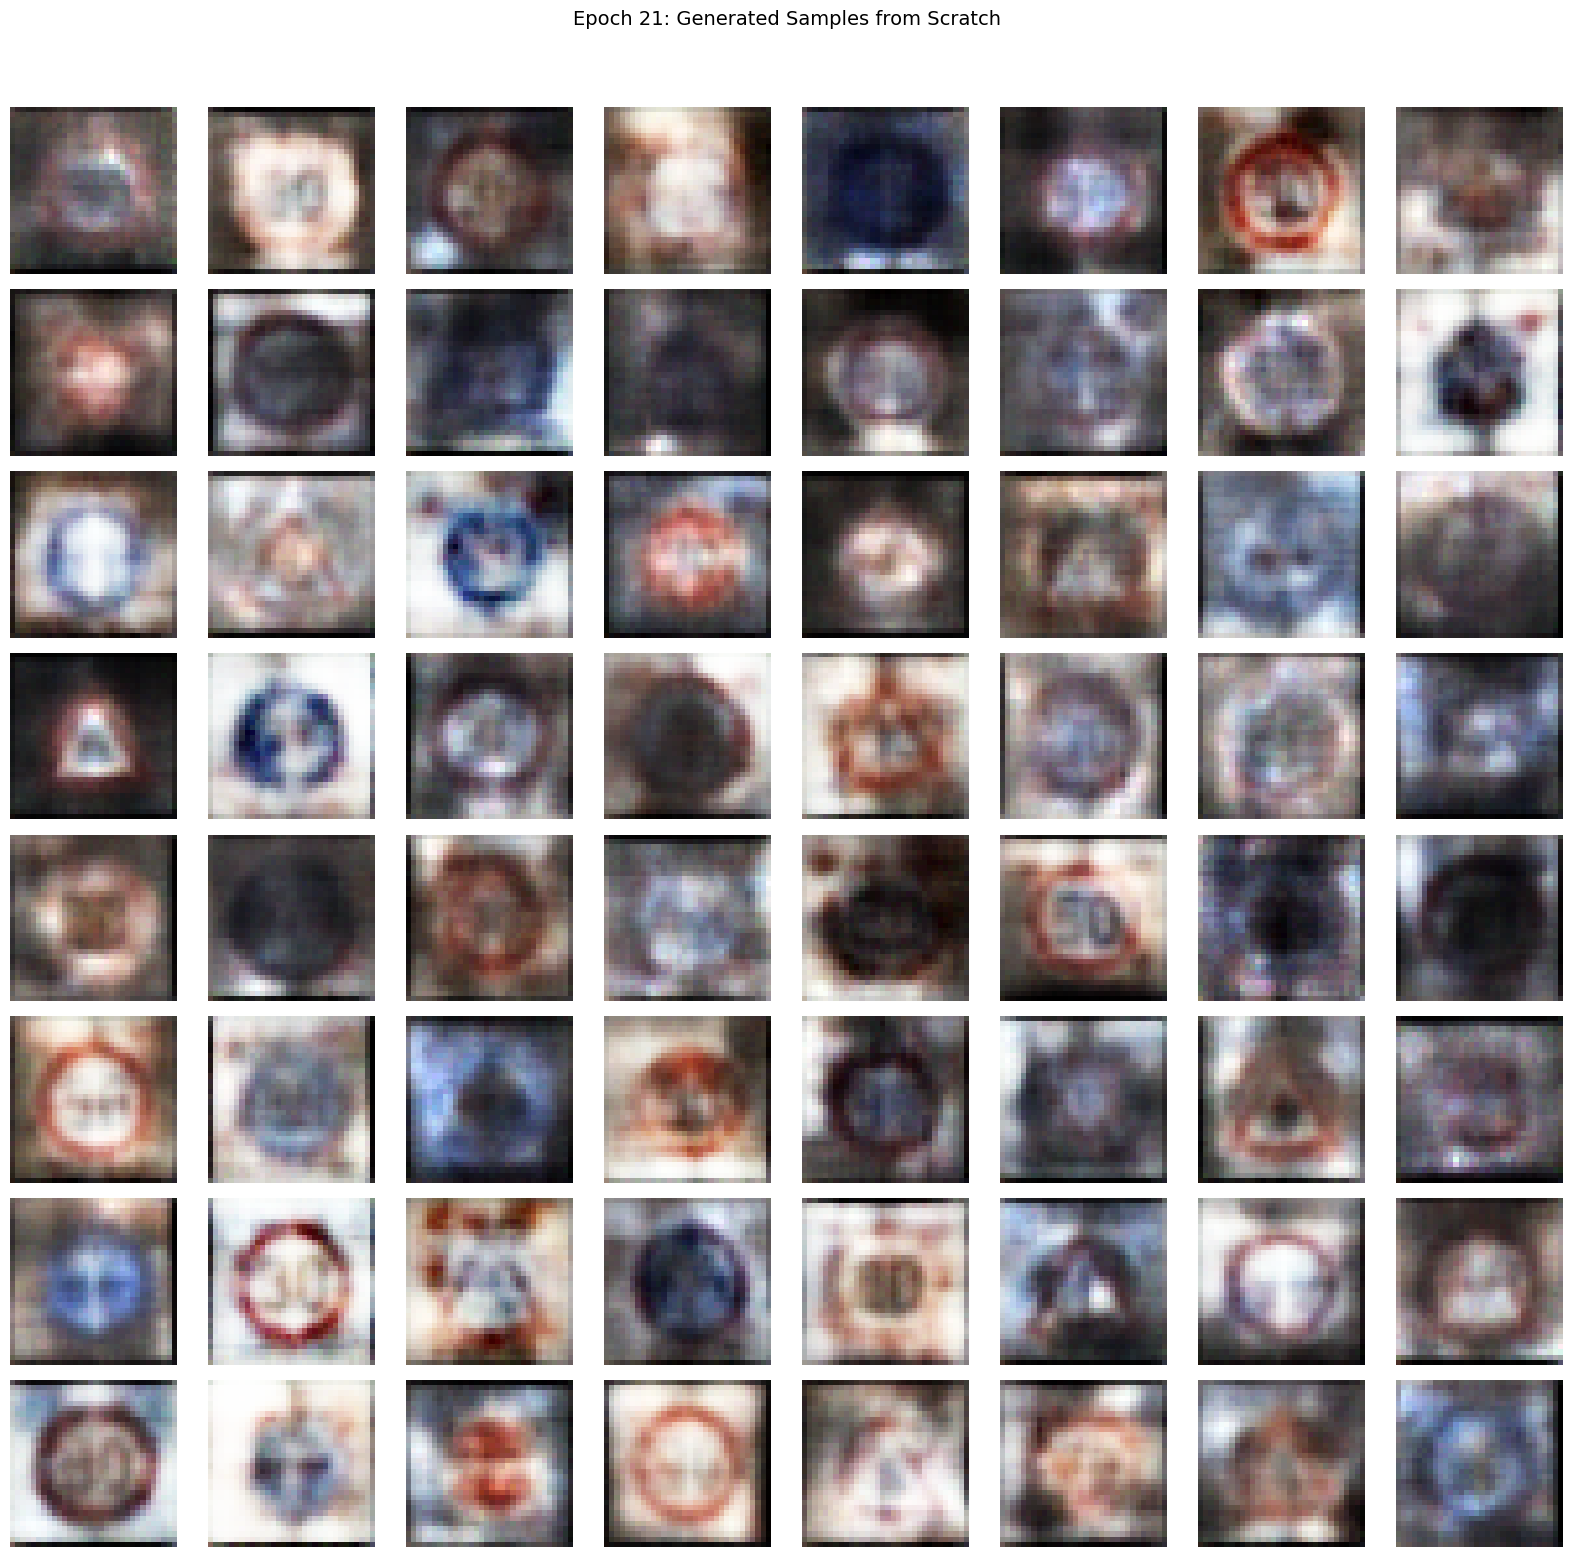

Epoch 22/100: Total Loss: 157.8652, Recon Loss: 116.0075, KLD Loss: 41.8577
Epoch 23/100: Total Loss: 156.1973, Recon Loss: 114.1783, KLD Loss: 42.0190
Epoch 24/100: Total Loss: 154.8556, Recon Loss: 112.6762, KLD Loss: 42.1795
Epoch 25/100: Total Loss: 153.5111, Recon Loss: 111.2146, KLD Loss: 42.2965
Epoch 26/100: Total Loss: 151.9197, Recon Loss: 109.5221, KLD Loss: 42.3975
Epoch 27/100: Total Loss: 150.8956, Recon Loss: 108.4076, KLD Loss: 42.4880
Epoch 28/100: Total Loss: 149.9615, Recon Loss: 107.3177, KLD Loss: 42.6438
Epoch 29/100: Total Loss: 148.7008, Recon Loss: 106.1589, KLD Loss: 42.5419
Epoch 30/100: Total Loss: 147.9667, Recon Loss: 105.2032, KLD Loss: 42.7635
Epoch 31/100: Total Loss: 147.2181, Recon Loss: 104.3368, KLD Loss: 42.8813


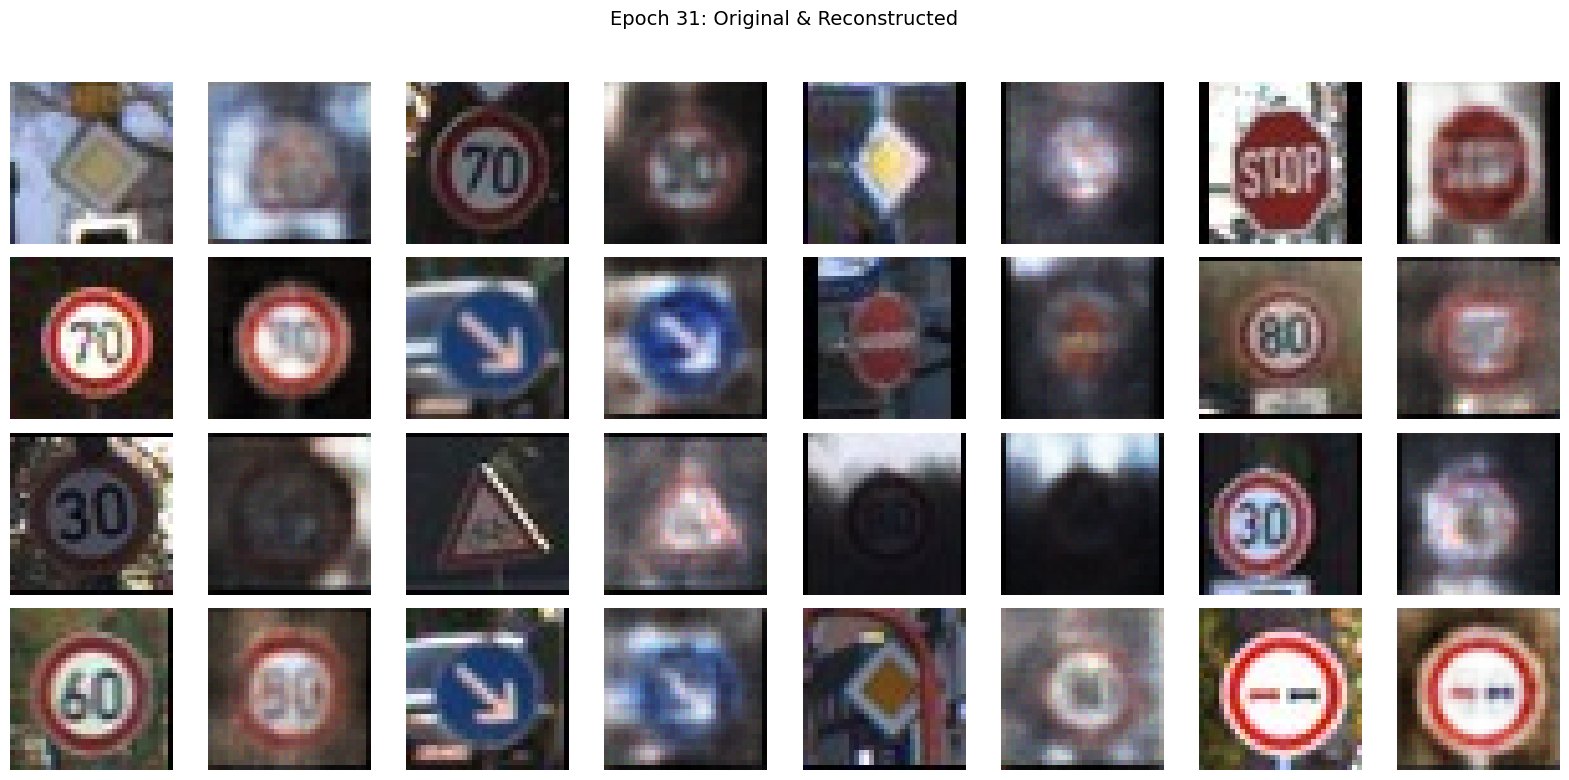

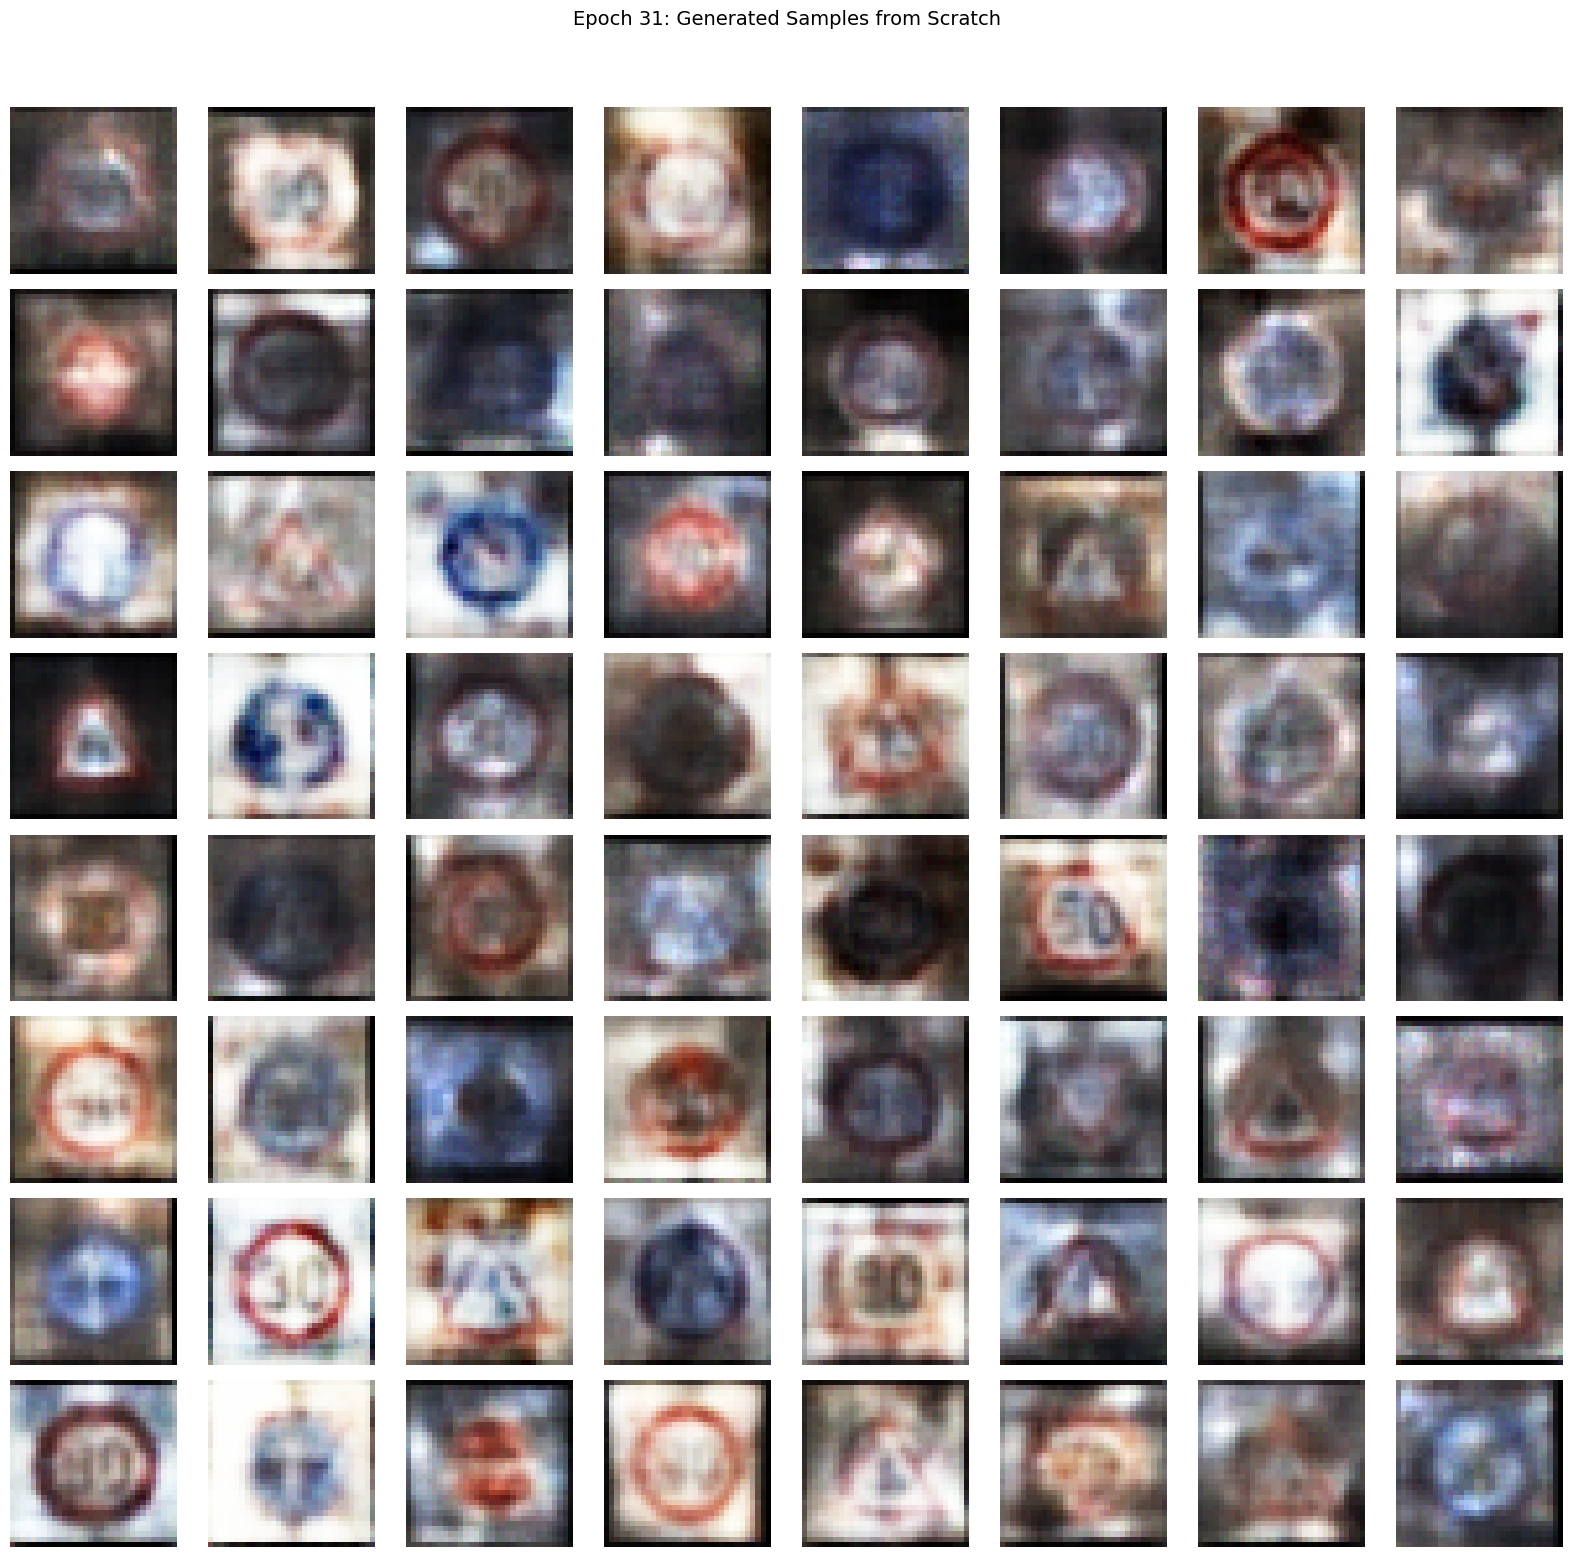

Epoch 32/100: Total Loss: 146.5069, Recon Loss: 103.5284, KLD Loss: 42.9785
Epoch 33/100: Total Loss: 145.4594, Recon Loss: 102.4354, KLD Loss: 43.0241
Epoch 34/100: Total Loss: 144.8120, Recon Loss: 101.8252, KLD Loss: 42.9868
Epoch 35/100: Total Loss: 144.0226, Recon Loss: 100.9274, KLD Loss: 43.0952
Epoch 36/100: Total Loss: 143.1885, Recon Loss: 100.0474, KLD Loss: 43.1411
Epoch 37/100: Total Loss: 142.4670, Recon Loss: 99.3151, KLD Loss: 43.1519
Epoch 38/100: Total Loss: 142.3031, Recon Loss: 98.9802, KLD Loss: 43.3230
Epoch 39/100: Total Loss: 141.7813, Recon Loss: 98.4774, KLD Loss: 43.3038
Epoch 40/100: Total Loss: 140.9857, Recon Loss: 97.6587, KLD Loss: 43.3270
Epoch 41/100: Total Loss: 140.6595, Recon Loss: 97.2890, KLD Loss: 43.3705


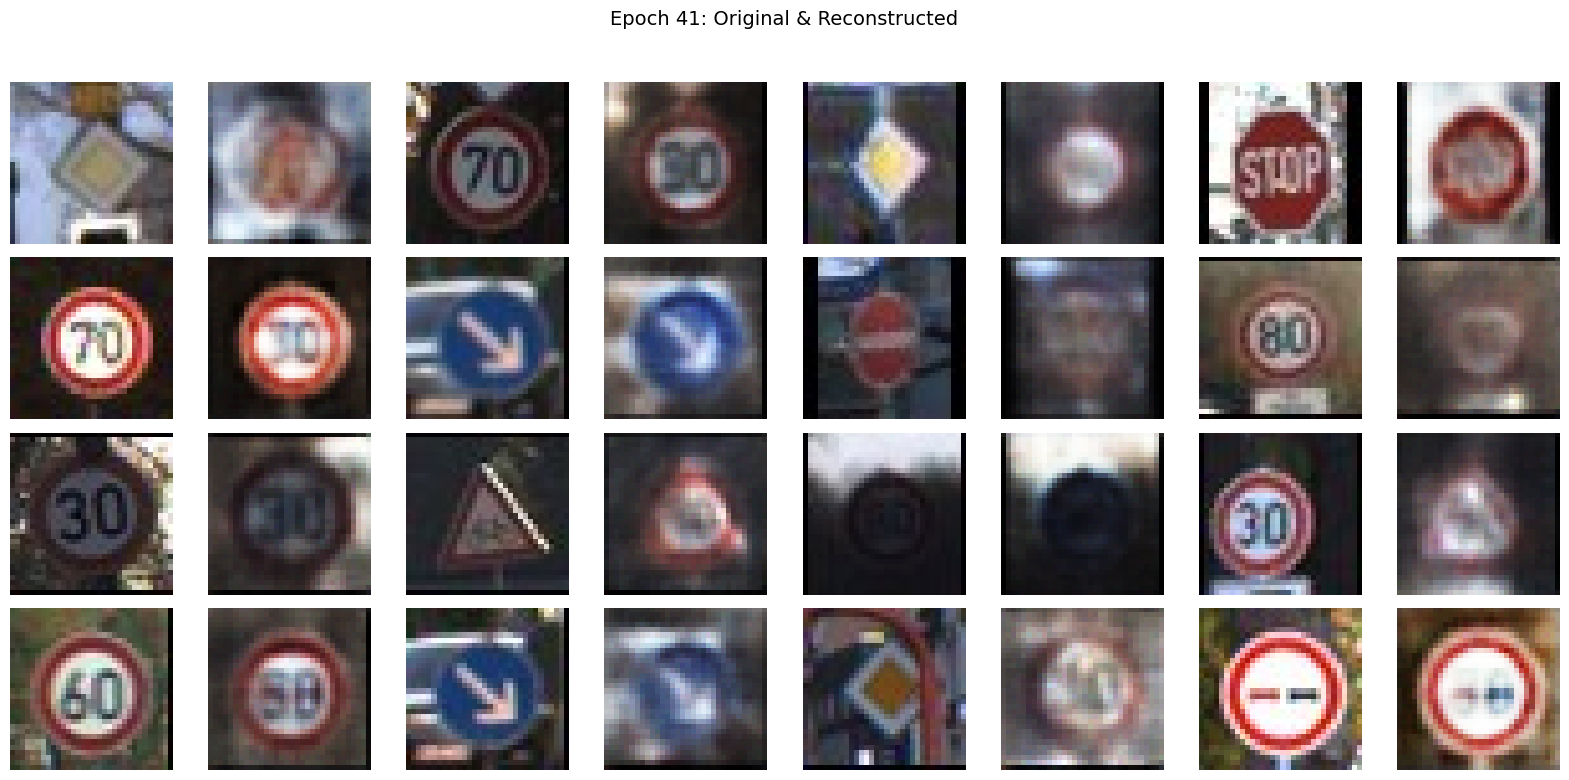

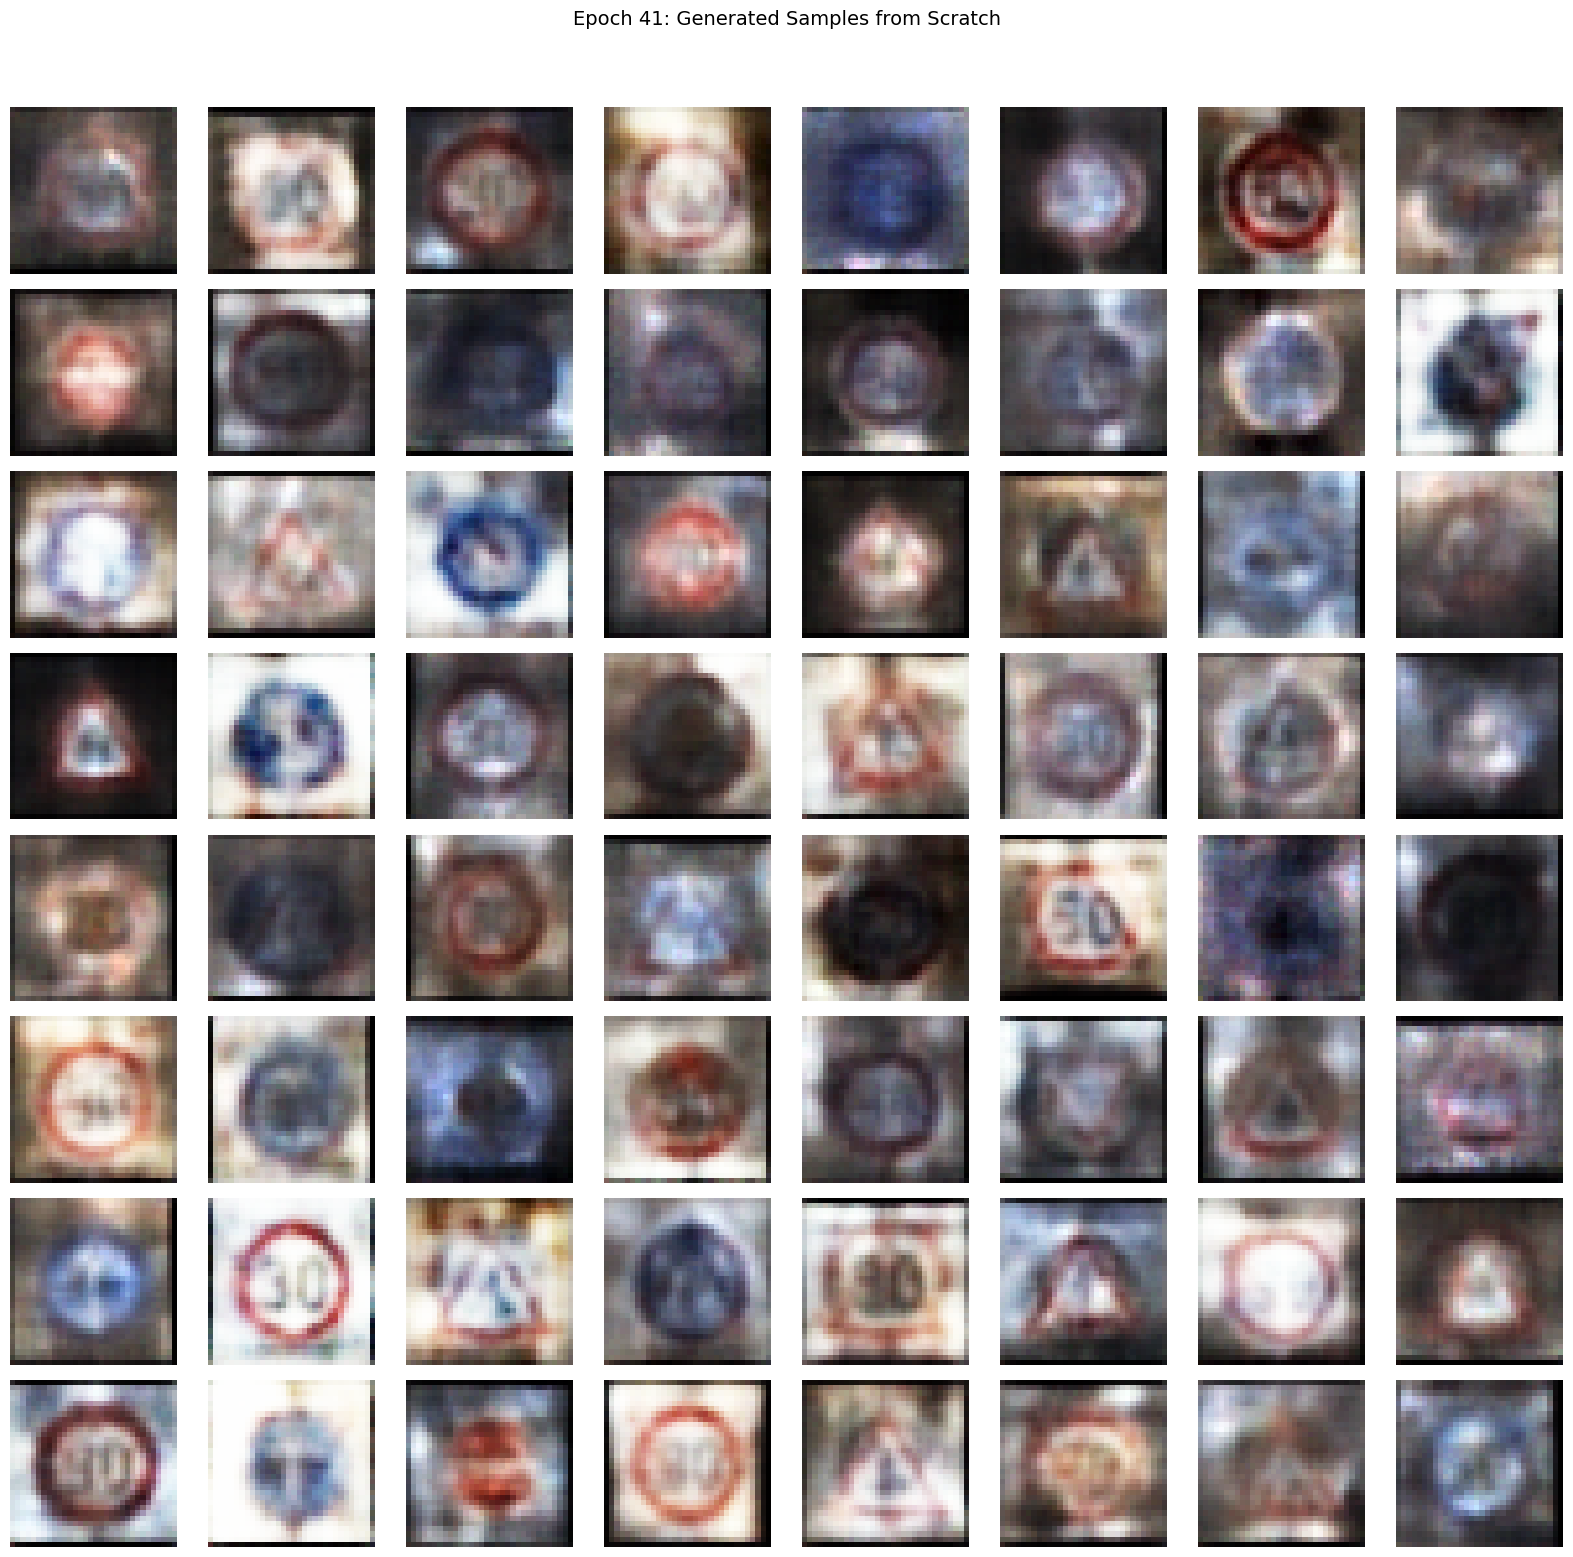

Epoch 42/100: Total Loss: 140.0259, Recon Loss: 96.5699, KLD Loss: 43.4561
Epoch 43/100: Total Loss: 139.5977, Recon Loss: 96.0651, KLD Loss: 43.5326
Epoch 44/100: Total Loss: 138.9905, Recon Loss: 95.4819, KLD Loss: 43.5086
Epoch 45/100: Total Loss: 138.3691, Recon Loss: 94.8110, KLD Loss: 43.5581
Epoch 46/100: Total Loss: 138.1321, Recon Loss: 94.4841, KLD Loss: 43.6480
Epoch 47/100: Total Loss: 137.7224, Recon Loss: 94.0291, KLD Loss: 43.6933
Epoch 48/100: Total Loss: 137.2403, Recon Loss: 93.6229, KLD Loss: 43.6174
Epoch 49/100: Total Loss: 136.8401, Recon Loss: 93.1020, KLD Loss: 43.7380
Epoch 50/100: Total Loss: 136.5755, Recon Loss: 92.8053, KLD Loss: 43.7702
Epoch 51/100: Total Loss: 136.5699, Recon Loss: 92.7620, KLD Loss: 43.8079


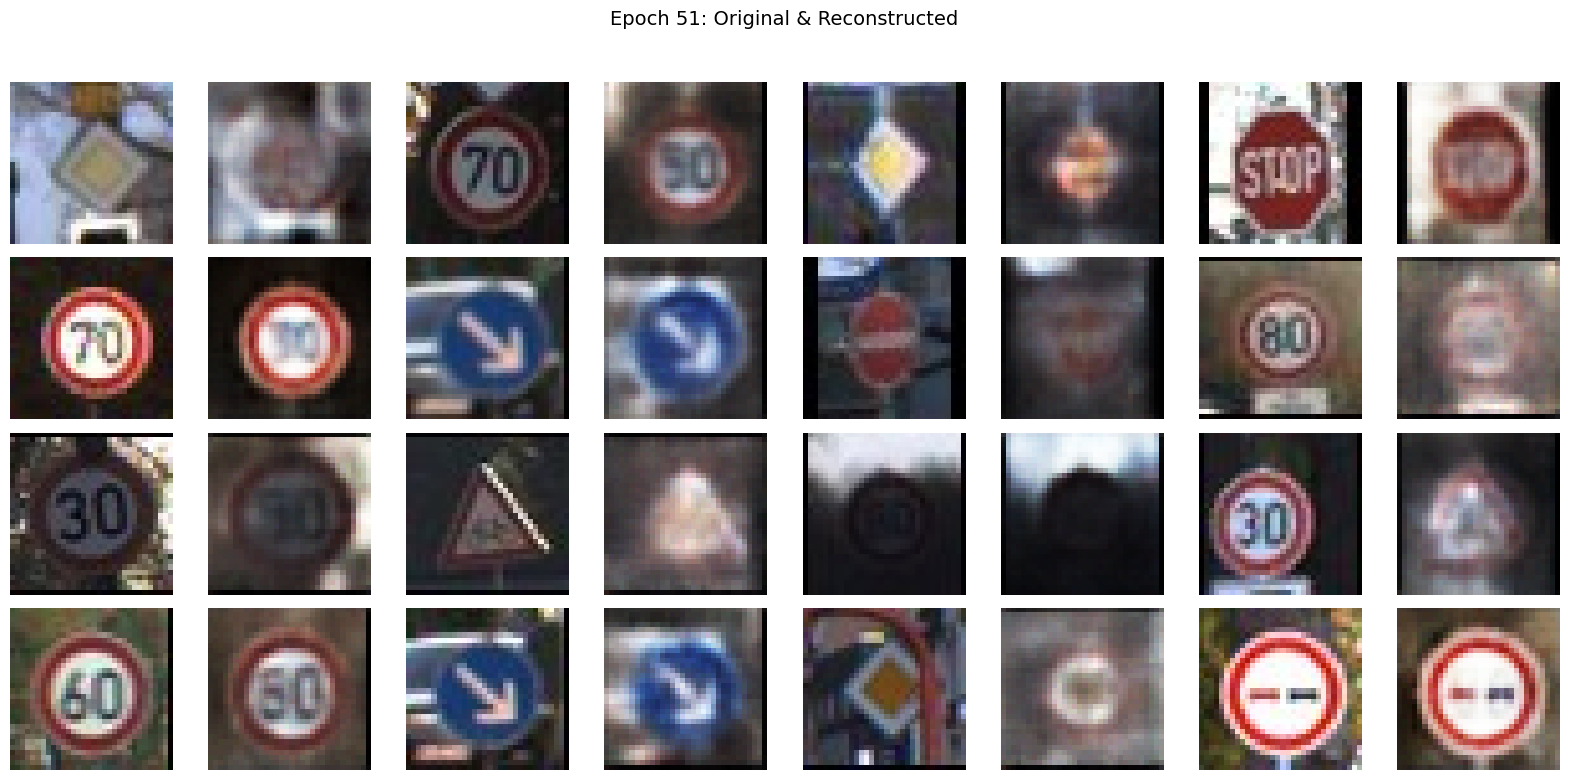

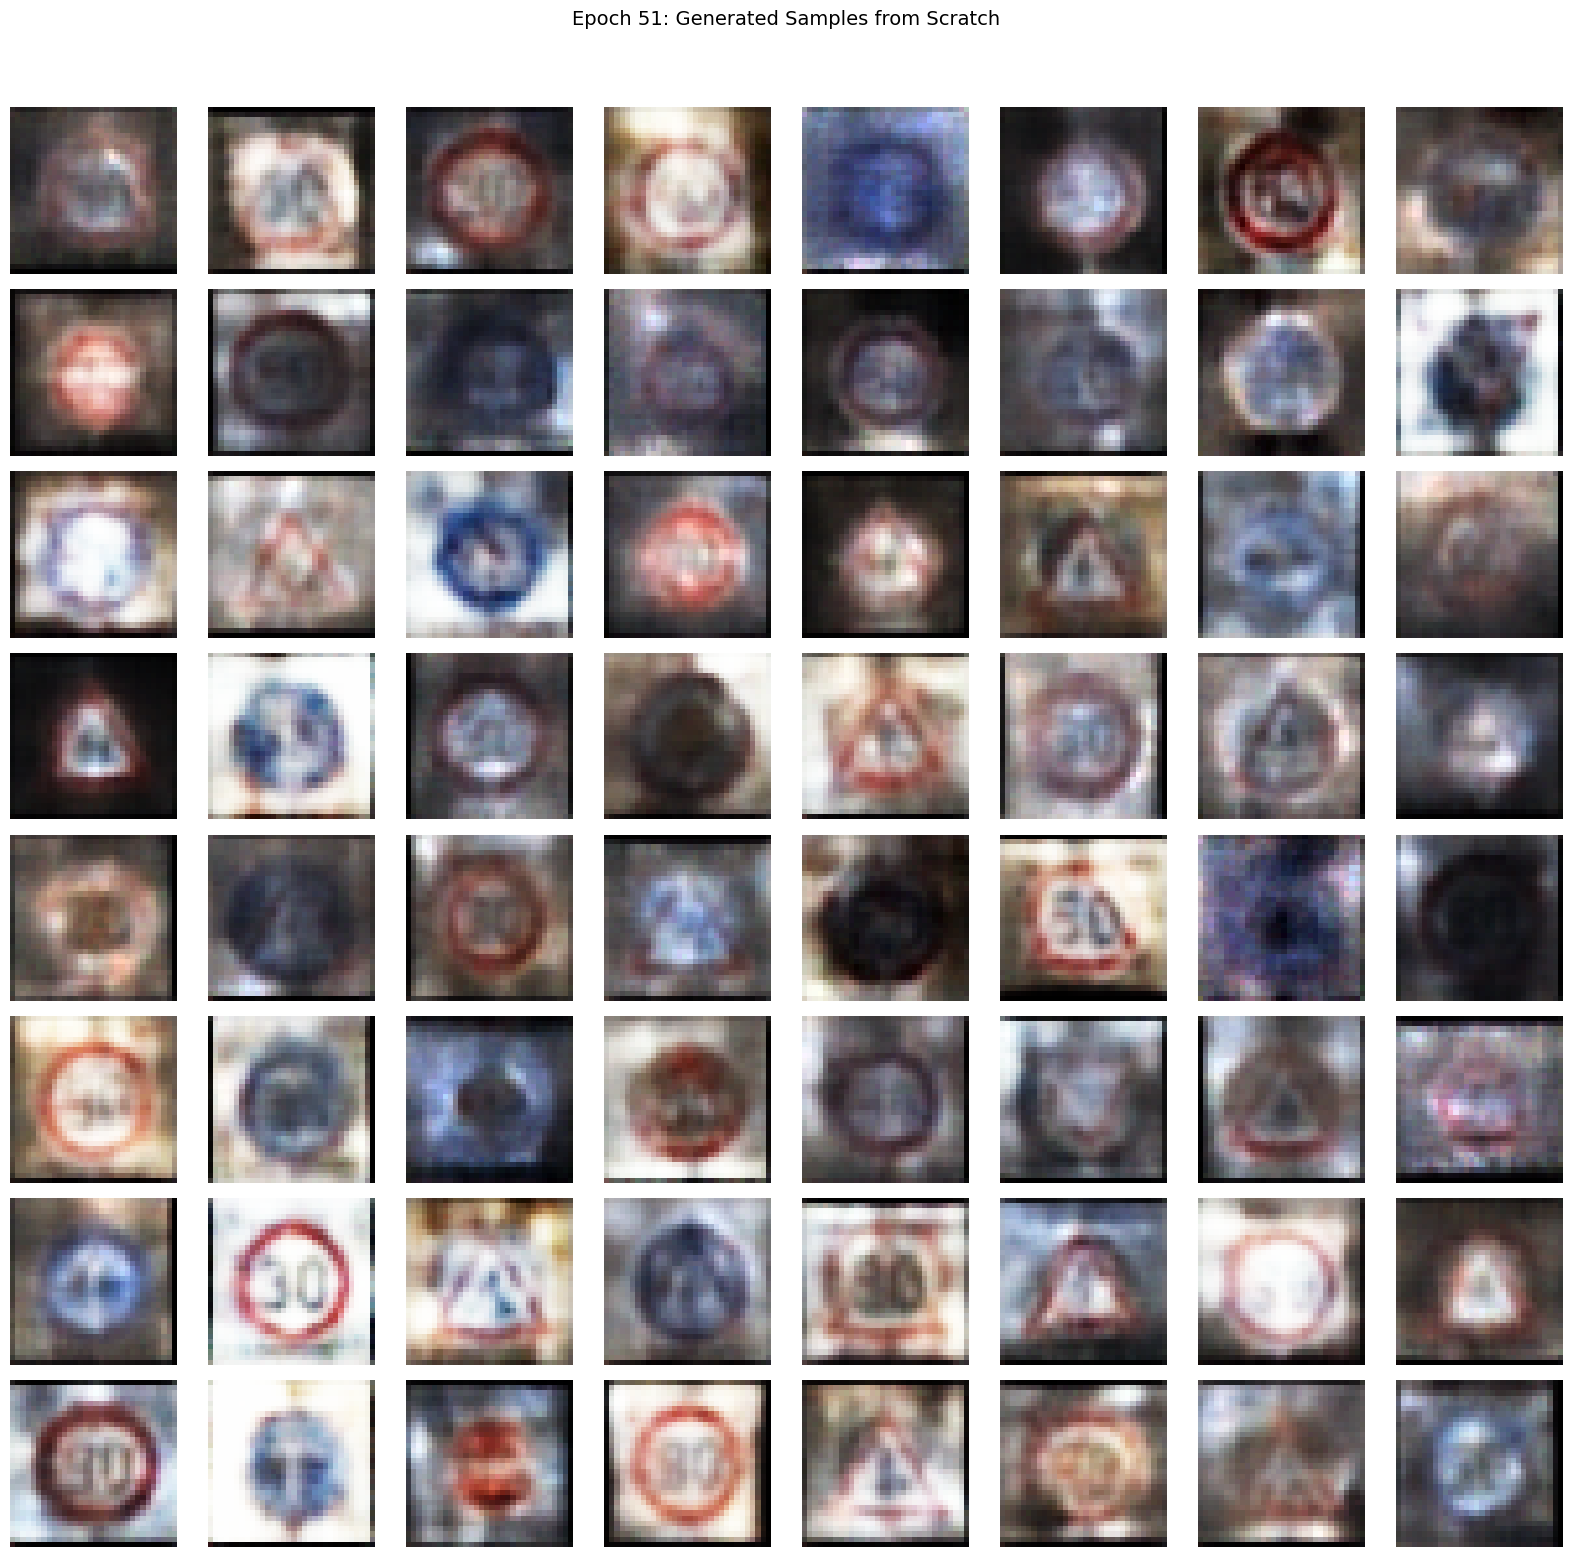

Epoch 52/100: Total Loss: 135.9906, Recon Loss: 92.1275, KLD Loss: 43.8632
Epoch 53/100: Total Loss: 135.5915, Recon Loss: 91.7904, KLD Loss: 43.8011
Epoch 54/100: Total Loss: 135.2343, Recon Loss: 91.3502, KLD Loss: 43.8841
Epoch 55/100: Total Loss: 135.3778, Recon Loss: 91.4013, KLD Loss: 43.9765
Epoch 56/100: Total Loss: 134.5872, Recon Loss: 90.6846, KLD Loss: 43.9026
Epoch 57/100: Total Loss: 134.5525, Recon Loss: 90.5658, KLD Loss: 43.9867
Epoch 58/100: Total Loss: 134.1448, Recon Loss: 90.1779, KLD Loss: 43.9669
Epoch 59/100: Total Loss: 133.6843, Recon Loss: 89.7824, KLD Loss: 43.9019
Epoch 60/100: Total Loss: 133.5964, Recon Loss: 89.5460, KLD Loss: 44.0504
Epoch 61/100: Total Loss: 133.2800, Recon Loss: 89.2390, KLD Loss: 44.0410


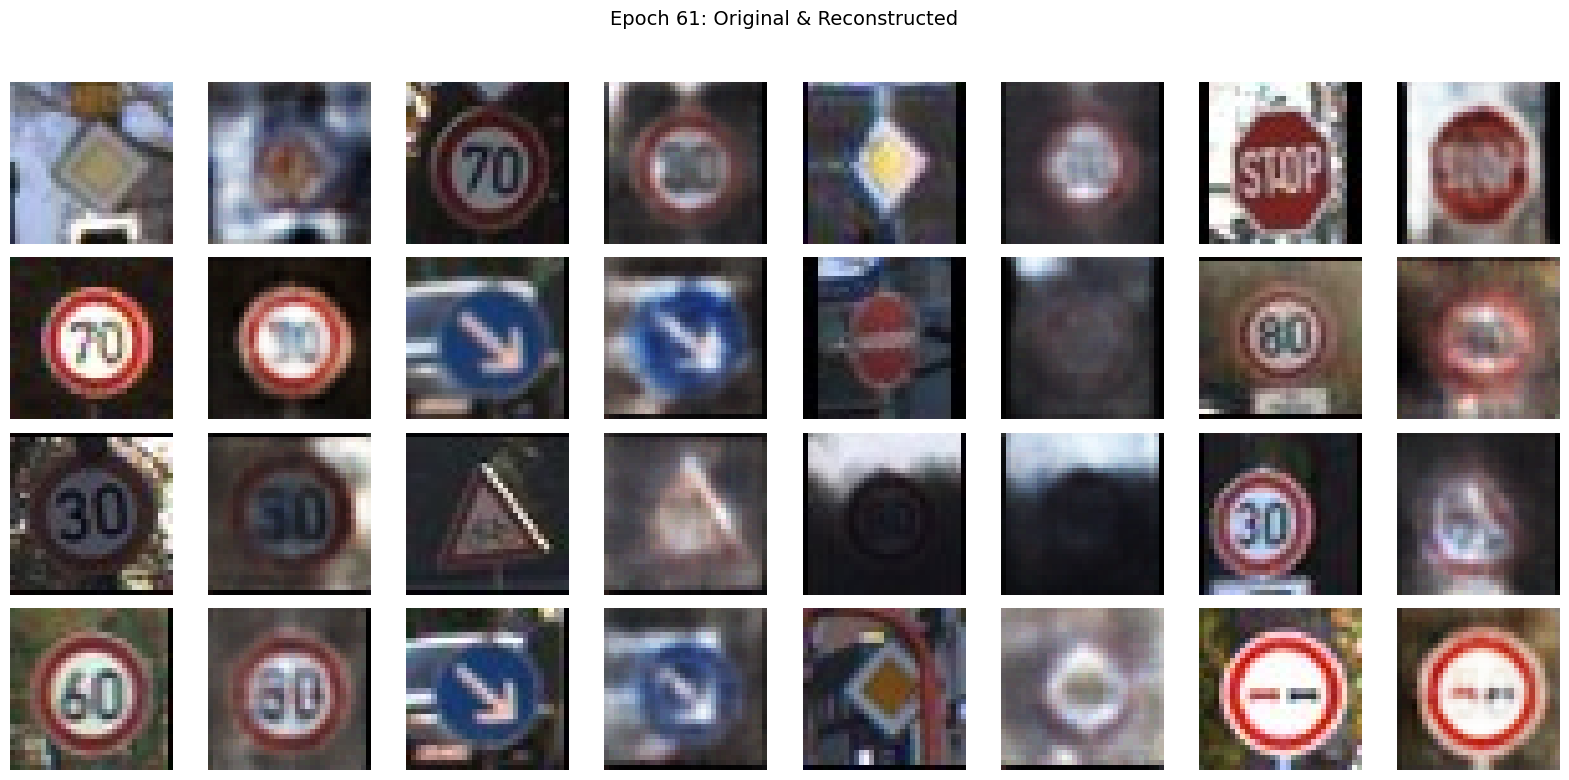

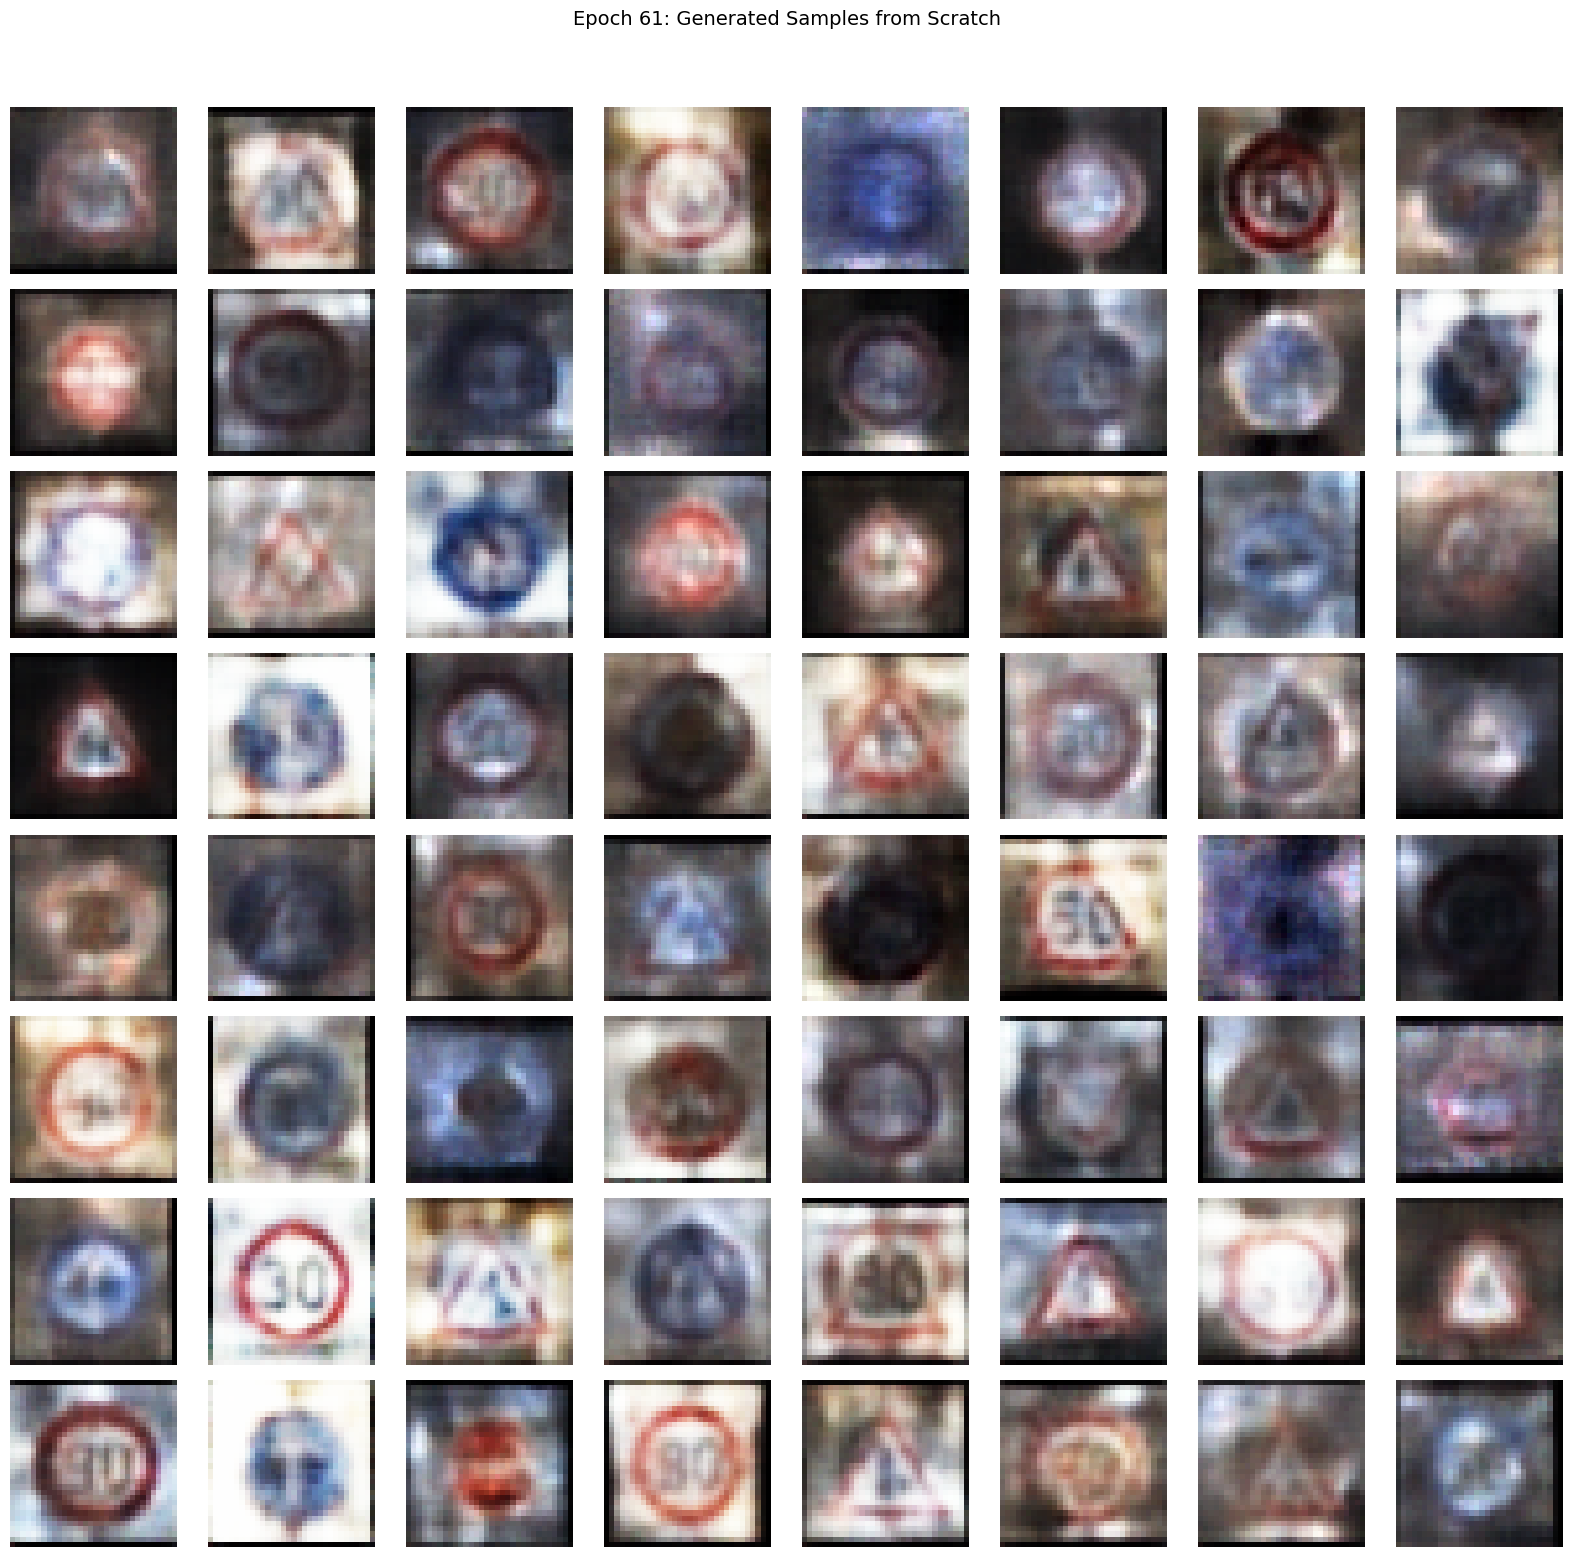

Epoch 62/100: Total Loss: 133.2066, Recon Loss: 89.0591, KLD Loss: 44.1474
Epoch 63/100: Total Loss: 132.7394, Recon Loss: 88.7181, KLD Loss: 44.0213
Epoch 64/100: Total Loss: 132.5055, Recon Loss: 88.4285, KLD Loss: 44.0770
Epoch 65/100: Total Loss: 132.5445, Recon Loss: 88.3811, KLD Loss: 44.1634
Epoch 66/100: Total Loss: 132.2578, Recon Loss: 88.1031, KLD Loss: 44.1547
Epoch 67/100: Total Loss: 132.0592, Recon Loss: 87.9502, KLD Loss: 44.1090
Epoch 68/100: Total Loss: 131.9563, Recon Loss: 87.7084, KLD Loss: 44.2480
Epoch 69/100: Total Loss: 131.8446, Recon Loss: 87.5839, KLD Loss: 44.2608
Epoch 70/100: Total Loss: 131.3774, Recon Loss: 87.1709, KLD Loss: 44.2065
Epoch 71/100: Total Loss: 131.4317, Recon Loss: 87.1796, KLD Loss: 44.2521


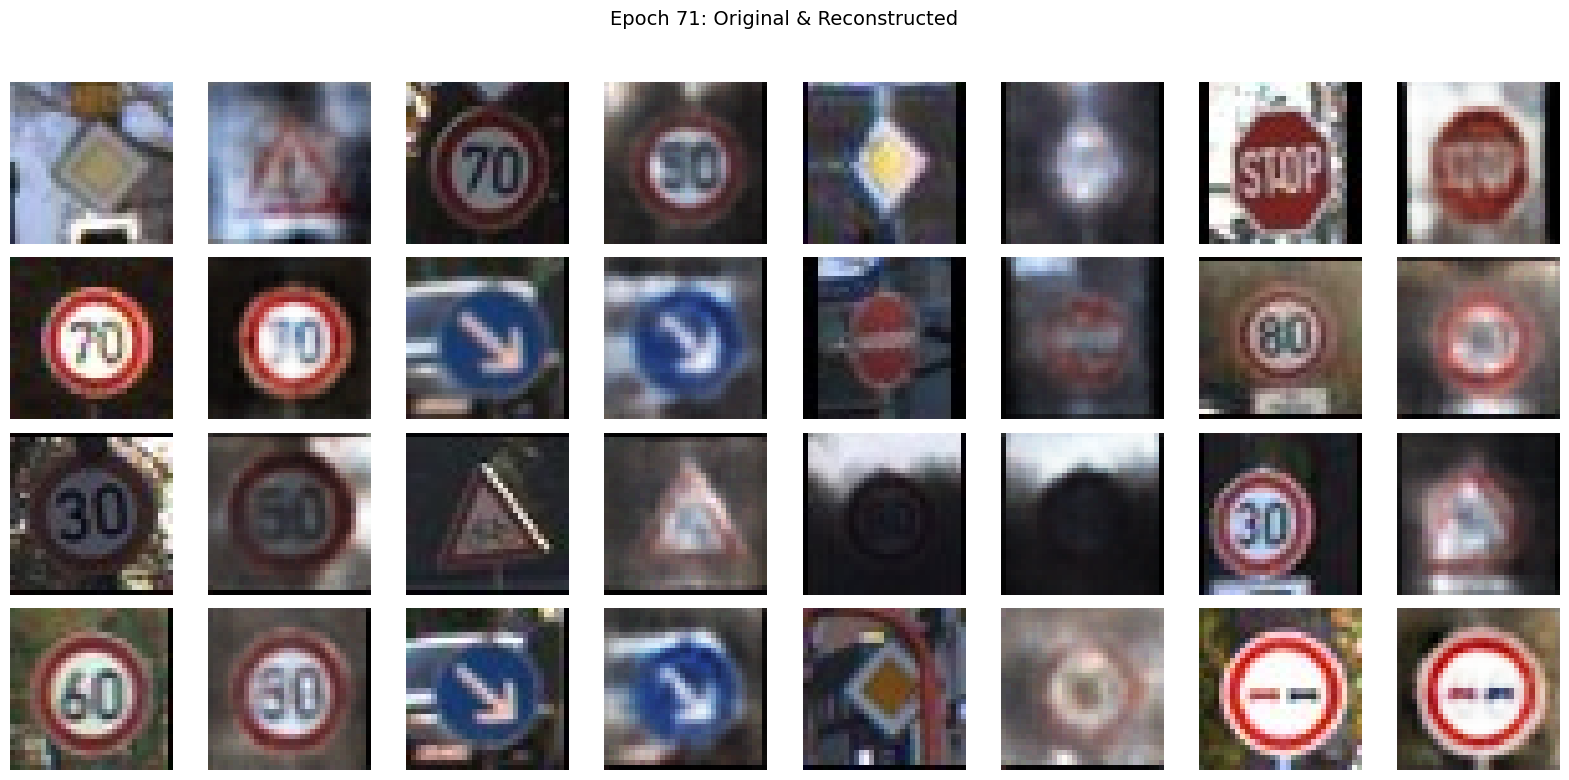

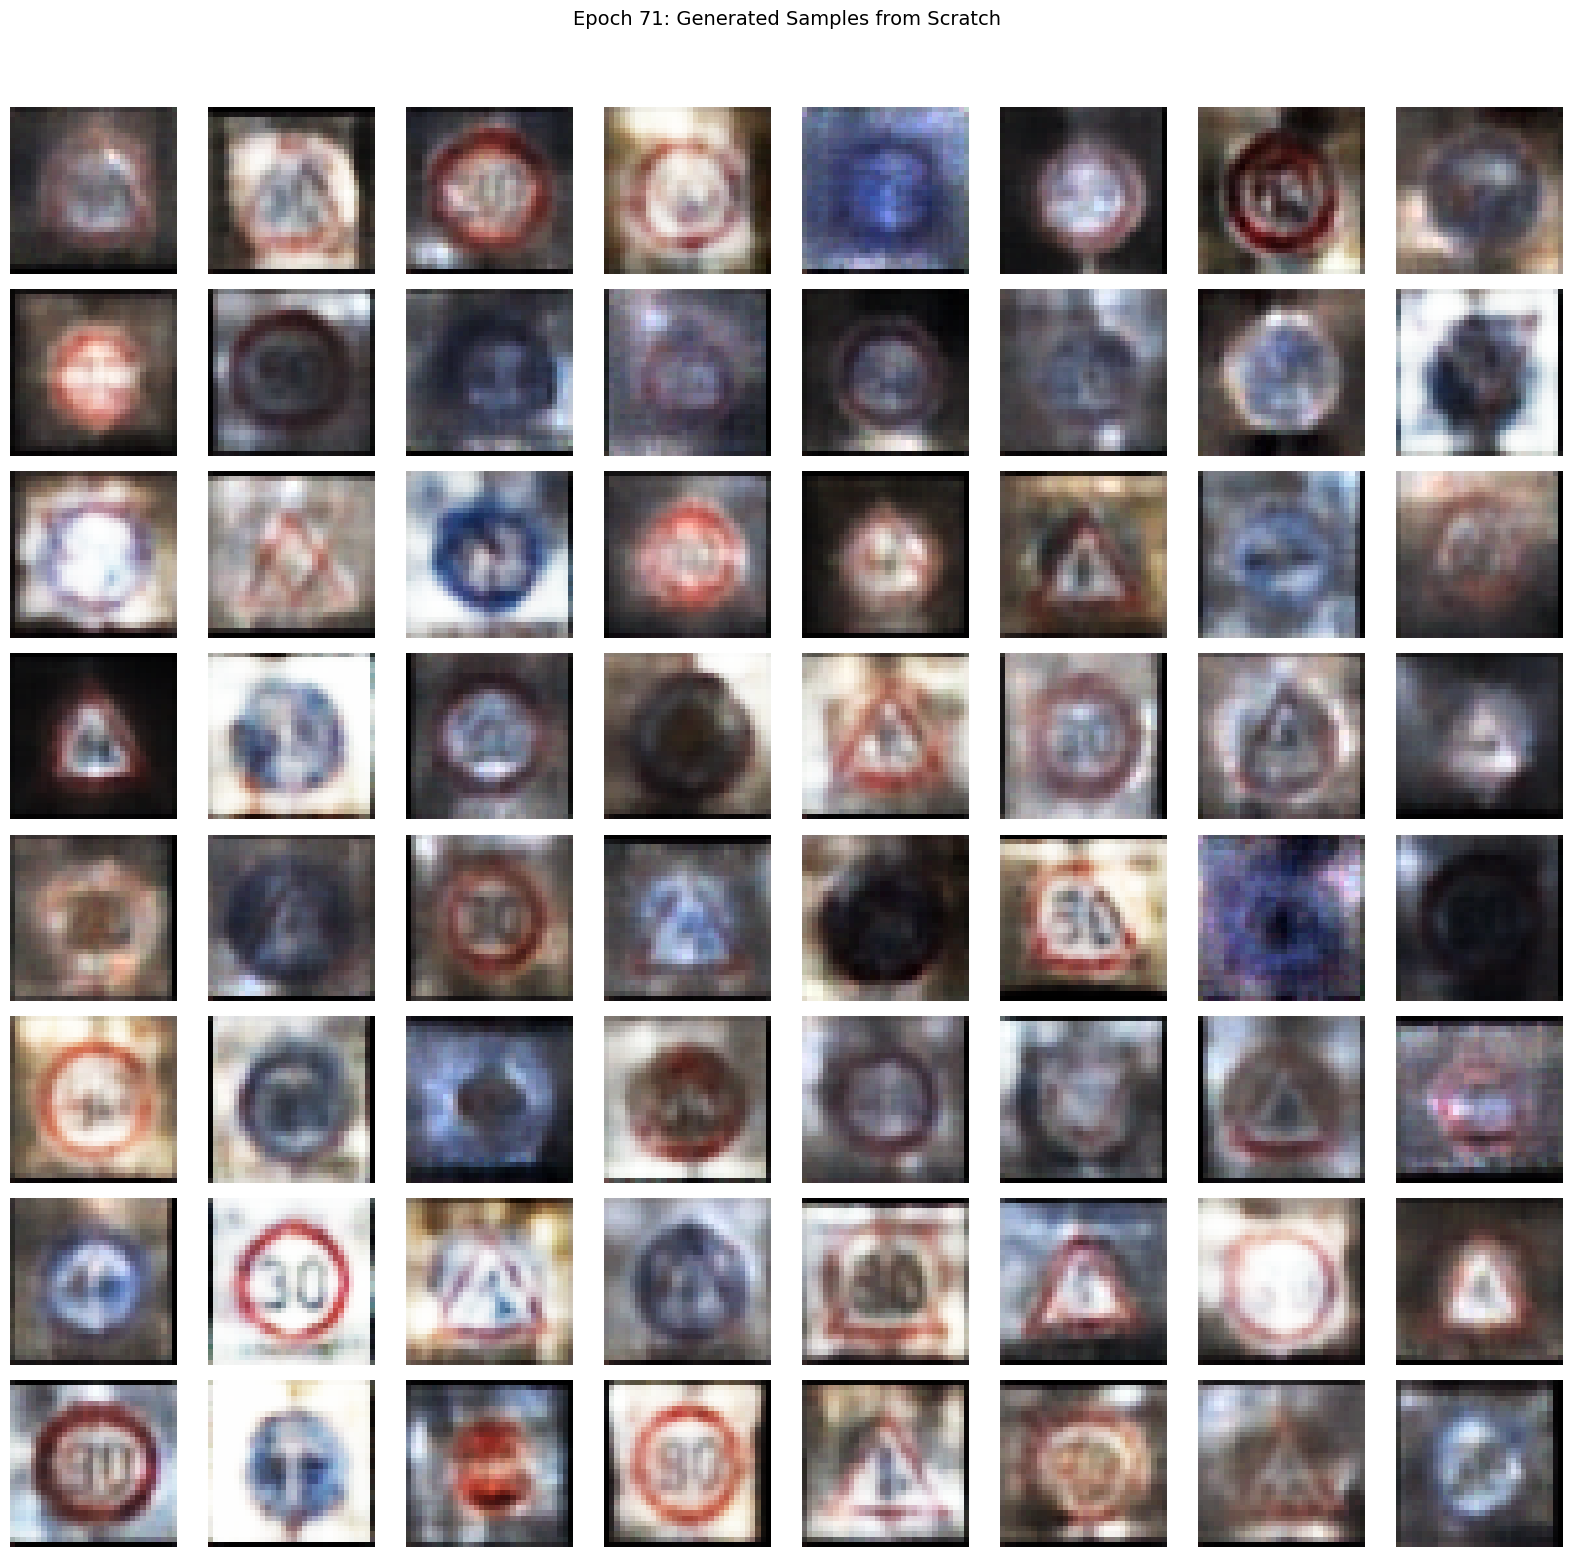

Epoch 72/100: Total Loss: 130.9501, Recon Loss: 86.7437, KLD Loss: 44.2065
Epoch 73/100: Total Loss: 130.8741, Recon Loss: 86.6342, KLD Loss: 44.2400
Epoch 74/100: Total Loss: 130.8795, Recon Loss: 86.5814, KLD Loss: 44.2981
Epoch 75/100: Total Loss: 130.6795, Recon Loss: 86.3197, KLD Loss: 44.3598
Epoch 76/100: Total Loss: 130.5250, Recon Loss: 86.2130, KLD Loss: 44.3120
Epoch 77/100: Total Loss: 130.2008, Recon Loss: 85.9361, KLD Loss: 44.2647
Epoch 78/100: Total Loss: 130.0797, Recon Loss: 85.7958, KLD Loss: 44.2839


KeyboardInterrupt: 

In [12]:
vae_trainer.fit(train_dl, num_epochs=100)